In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import umap.umap_ as umap
from stop_words import get_stop_words
import re
import string
from sentence_transformers import SentenceTransformer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

2023-04-02 22:39:03.112106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 22:39:03.185394: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-02 22:39:03.185410: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-02 22:39:03.631124: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
def predict_topics_with_kmeans(embeddings,num_topics):
  kmeans_model = KMeans(num_topics)
  kmeans_model.fit(embeddings)
  topics_labels = kmeans_model.predict(embeddings)
  return topics_labels


def plot_embeddings(embedding, labels,title):

    labels = np.array( labels )
    distinct_labels =  set( labels )
    
    n = len(embedding)
    counter = Counter(labels)
    for i in range(len( distinct_labels )):
        ratio = (counter[i] / n )* 100
        cluster_label = f"cluster {i}: { round(ratio,2)}"
        x = embedding[:, 0][labels == i]
        y = embedding[:, 1][labels == i]
        plt.plot(x, y, '.', alpha=0.4, label= cluster_label)
    plt.legend(title="Topic",loc = 'upper left', bbox_to_anchor=(1.01,1))
    plt.title(title)
    

def reduce_umap(embedding):
  reducer = umap.UMAP()
  embedding_umap = reducer.fit_transform( embedding  )
  return embedding_umap

def reduce_pca(embedding):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform( embedding )
    print( "pca explained_variance_ ",pca.explained_variance_)
    print( "pca explained_variance_ratio_ ",pca.explained_variance_ratio_)
    
    return reduced

def reduce_tsne(embedding):
    tsne = TSNE(n_components=2)
    reduced = tsne.fit_transform( embedding )
    
    return reduced

In [3]:

def only_letters(tested_string):
    for letter in tested_string:
        if letter not in "abcdefghijklmnopqrstuvwxyz":
            return False
    return True

#I just did an adhoc cleaning, as I see documents
#have some non English characters, so I use above method only_letters
#to filter instead of default isalpha python method
def clean_data(s): 
    s = s.replace(">","").lower()
    if "lines:" in s :
        index = s.index("lines:")
        s = s[index+10:] 
        
    word_list = word_tokenize(s)
    cleaned = []
    for w in word_list:
        if w not in stop_words:
            if w in string.punctuation or only_letters(w):
                if w in string.punctuation or len( set(w) ) > 1:
                    cleaned.append( w)
    return " ".join(cleaned) ,cleaned           
            

#from documents clean sentence and return vocublary of sentence
def build_data(docs):

    n_docs = len(docs)
    sentences = []  # sentences
    token_lists = []  # words vocublary
    
    for i in range(len(docs)):
        sentence,token_list = clean_data(docs[i])
        if token_list: #if not all items eleminated
            sentences.append(sentence)
            token_lists.append(token_list)
        
    return sentences, token_lists


In [4]:
model_name = "distiluse-base-multilingual-cased-v1"
model_bert = SentenceTransformer(model_name)

/home/joao/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
stop_words = get_stop_words('pt')

In [6]:
df = pd.read_csv("tatoeba_with_preds.csv")
print(df.head())
df = df[:10000]

   Unnamed: 0   ID-PT                                  PT    ID-EN  \
0           0  146680  Uma menina chorando abriu a porta.   267881   
1           1  180624          Vamos tentar alguma coisa!     1276   
2           2  182184                  Preciso ir dormir.     1277   
3           3  182184                  Preciso ir dormir.  2047094   
4           4  182185          O sinal '&' significa 'e'.    74007   

                               EN  Pred Pred_CEFR  
0  A crying girl opened the door.     1        A2  
1            Let's try something.     1        A2  
2          I have to go to sleep.     1        A2  
3          I need to go to sleep.     1        A2  
4  The sign '&' stands for 'and'.     1        A2  


In [7]:
raw_sentences = []
for s in df["PT"]:
  raw_sentences.append(s)
print(f"Number of raw sentences: {len(raw_sentences)}")

Number of raw sentences: 10000


In [8]:
test_number = 55
print(f"Sentence before cleaning: {raw_sentences[test_number]}")

Sentence before cleaning: Ah, quando eles se encontrarão novamente?


In [9]:
sentences, token_lists = build_data(raw_sentences)

In [10]:
print(len(sentences))

10000


In [11]:
print(f"Sentence after cleaning: {sentences[test_number]}")

Sentence after cleaning: ah , novamente ?


In [12]:
num_topics = 250

In [13]:
embedding_bert = np.array(model_bert.encode(sentences, show_progress_bar=True))

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [14]:
#Bert embeddings are shape of 768
print("Bert Embedding shape", embedding_bert.shape)
print("Bert Embedding sample", embedding_bert[0][0:50])

Bert Embedding shape (10000, 512)
Bert Embedding sample [ 0.03518562  0.0173832  -0.03146609  0.03567033 -0.08210381 -0.04515691
 -0.01815085 -0.06104125  0.0513412   0.03501677 -0.00822499  0.0282339
 -0.04441842 -0.04423658  0.00149966  0.03673334  0.01287965  0.01484724
  0.0249856  -0.08019653  0.0079097  -0.04584907 -0.02402237  0.00969834
 -0.00630131  0.08087478 -0.00286091 -0.02134967 -0.03900349 -0.02015596
  0.01094211  0.03452741 -0.04358385 -0.01598318 -0.05529876  0.01389833
 -0.03804053 -0.01518839  0.08882543 -0.02947902 -0.01427315  0.0129686
 -0.00269113 -0.02083671  0.03047349  0.0363929   0.08018866 -0.06224879
 -0.02281996 -0.008859  ]


In [15]:
#Apply Kmeans for Bert Vectors  with T-sne  dimension reduction

# embedding_bert_tsne =  reduce_tsne( embedding_bert )
# labels_bert_tsne  = predict_topics_with_kmeans(embedding_bert_tsne, num_topics)
# plot_embeddings(embedding_bert_tsne,labels_bert_tsne,"Bert with T-sne")

/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


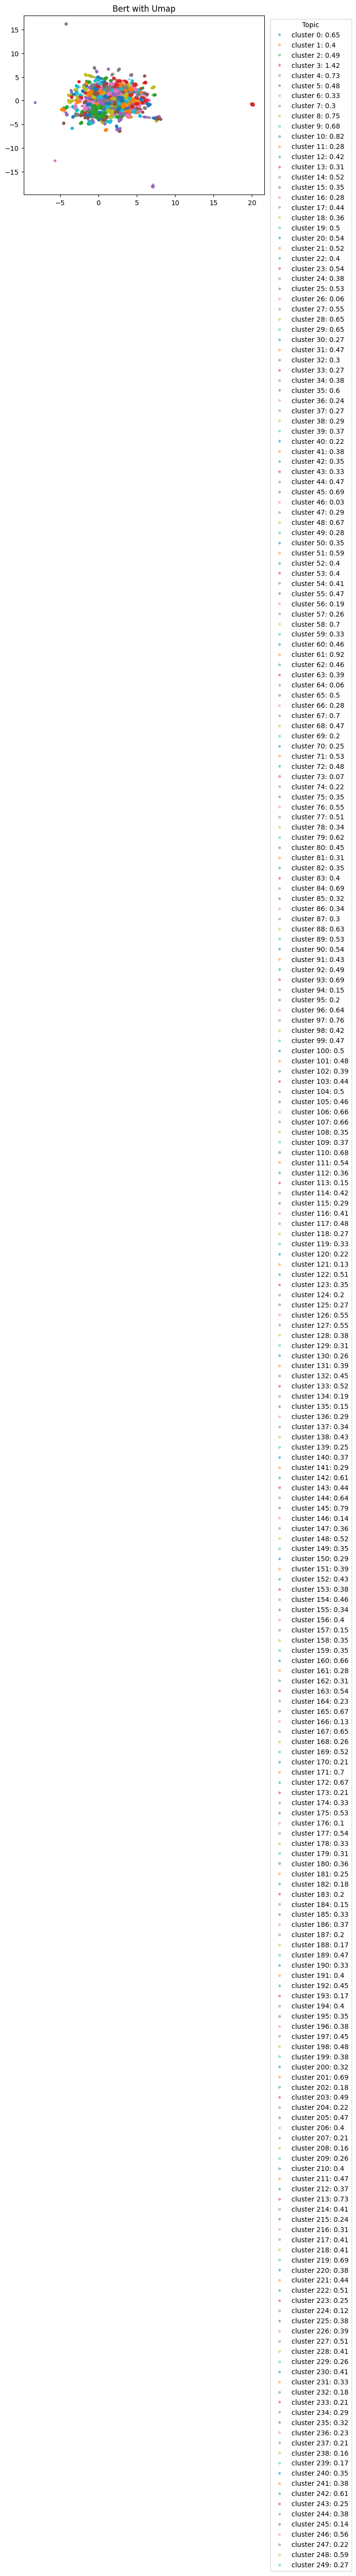

In [16]:
#Apply Kmeans for Bert Vectors  with Umap  dimension reduction

embedding_umap_bert = reduce_umap( embedding_bert )
labels_bert_umap  = predict_topics_with_kmeans(embedding_umap_bert, num_topics)
plot_embeddings(embedding_umap_bert, labels_bert_umap,"Bert with Umap")

In [17]:
print("Silhouette score:" )

# print("Bert with Tsne", silhouette_score(embedding_bert_tsne, labels_bert_tsne) )
print("Bert with Umap",  silhouette_score(embedding_umap_bert , labels_bert_umap ) )

Silhouette score:
Bert with Umap 0.55174845


In [18]:
for i in range(len(raw_sentences)):
    if labels_bert_umap[i] == 30:
        print(f"{raw_sentences[i]}")

A economia japonesa desenvolveu-se rapidamente.
Os olhos dele são azuis.
Eu não posso ver ninguém como um herói nacional a não ser Shigeo Nagashima.
Eles são japoneses?
Seus olhos são azuis.
Jane pode cantar uma parte da música japonesa.
A língua japonesa tem expressões honoríficas.
Os japoneses vivem em harmonia com a natureza.
Eu tenho que terminar um artigo sobre a economia japonesa.
Esse suéter azul é muito bonito.
Em geral, os japoneses são trabalhadores esforçados.
Eles são japoneses ou chineses?
O céu é azul.
Alguns japoneses são tão tímidos a ponto de parecerem rudes.
Meus olhos são azuis.
Os japoneses fazem três refeições por dia.
Ela tem olhos azuis.
Os japoneses têm olhos negros.
Os japoneses têm olhos escuros.
É algo como "olha, eu vi um papel azul quadrado agorinha!".
Ela é uma chinesa muçulmana de olhos azuis.
Os carros japoneses são muito populares.
Usarei o vestido azul.
As estátuas de Buda são obras notáveis na arte japonesa.
Ele está muito interessado na língua japone